In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
      def show_image(title,img):
        height, width = img.shape[:2]
        cv2.namedWindow(title, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(title, width, height)
        cv2.imshow(title, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        show_images([img],[title])
      def show_image_with_contours(title,img,contours):
        todraw=img.copy()
        height, width = todraw.shape[:2]
        cv2.drawContours(todraw, contours, -1, (0,255,0), 3)
        cv2.namedWindow(title, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(title, width, height)
        cv2.imshow(title, todraw)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        show_images([todraw],[title])

In [3]:
class TextExtractionTable:
      contours=None
      gscale_img=None
      def __init__(self, image):
        self.image = image  
        self.gscale_img=cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
      def binary_threshold(self):
         self.image = cv2.adaptiveThreshold(self.gscale_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,75,15)
      def morph_op(self):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
        opening = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel) 
        self.image=closing 
      def remove_v_h_lines(self):
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 6))
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
        eroded_image_v = cv2.erode(self.image, vertical_kernel, iterations=5)
        eroded_image_h = cv2.erode(self.image, horizontal_kernel, iterations=4)
        subtracted_image = cv2.subtract(self.image, eroded_image_h)
        subtracted_image = cv2.subtract(subtracted_image, eroded_image_v)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        subtracted_image = cv2.morphologyEx(subtracted_image, cv2.MORPH_OPEN, kernel)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        subtracted_image = cv2.morphologyEx(subtracted_image, cv2.MORPH_CLOSE, kernel)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        subtracted_image = cv2.morphologyEx(subtracted_image, cv2.MORPH_OPEN, kernel)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
        subtracted_image = cv2.morphologyEx(subtracted_image, cv2.MORPH_CLOSE, kernel)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        subtracted_image=cv2.dilate(subtracted_image,kernel,iterations=2)
        self.image=subtracted_image
      def get_contours(self):
        self.contours, hierarchy = cv2.findContours(self.image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      def filter_h_contours(self):
        boxes_h = np.array([cv2.boundingRect(c) for c in self.contours])
        #! These first two columns typically represent the top-left corner coordinates of the bounding boxes (x and y).
        #! The last two columns represent the width and height of the bounding box, respectively.
        #! calculate the center of the bounding boxes
        centers_h = boxes_h[:, :2] + boxes_h[:, 2:] / 2
        #! convert centres to a column vector with either x or y distances then generate a matrix of distances from each centre of #rows = #centres and #cols = #centres
        #! remove contours with no neighbours vertically
        horizontal_distances = np.abs(centers_h[:, 0][:, np.newaxis] - centers_h[:, 0])
        horizontal_distances[horizontal_distances <= 15] = 0
        horizontal_distances[np.arange(horizontal_distances.shape[0])[:, np.newaxis] == np.arange(horizontal_distances.shape[1])] = 1000000
        #! count the number of neighbor contours vertically
        num_zero_indices_h = np.sum(horizontal_distances == 0, axis=1)
        indices_to_remove_h = np.where(num_zero_indices_h < np.ceil(np.mean(num_zero_indices_h)))

        if (len(num_zero_indices_h) > 100):
          indices_to_remove_h = np.where(num_zero_indices_h < 4)

        mask_h = np.ones(len(self.contours), dtype=bool)
        mask_h[indices_to_remove_h[0]] = False
        self.contours = [np.array(contour) for i, contour in enumerate(self.contours) if i not in indices_to_remove_h[0]]
      def filter_v_contours(self):
        #! remove contours with no neighbours horizontally
        boxes_y = np.array([cv2.boundingRect(c) for c in self.contours])
        centers_y = boxes_y[:, :2] + boxes_y[:, 2:] / 2

        vertical_distances = np.abs(centers_y[:, 1][:, np.newaxis] - centers_y[:, 1]) 
        vertical_distances[vertical_distances <= 15] = 0
        vertical_distances[np.arange(vertical_distances.shape[0])[:, np.newaxis] == np.arange(vertical_distances.shape[1])] = 1000000
        #! count the number of neighbor contours horizontally
        num_zero_indices_y = np.sum(vertical_distances == 0, axis=1)
        indices_to_remove_y = np.where(num_zero_indices_y < np.ceil(np.mean(num_zero_indices_y)))
        if (len(num_zero_indices_y) > 100):
            indices_to_remove_y = np.where(num_zero_indices_y < 4)
        mask_v = np.ones(len(self.contours), dtype=bool)
        mask_v[indices_to_remove_y[0]] = False
        self.contours = [np.array(contour) for i, contour in enumerate(self.contours) if i not in indices_to_remove_y[0]]
      def draw_rect(self):
        todraw=self.gscale_img.copy()
        rectangles = np.array([cv2.boundingRect(c) for c in self.contours])
        x_offset=15
        y_offset=2
        for rect in rectangles:
            x, y, w, h = rect
            cv2.rectangle(todraw, (x-x_offset, y-y_offset-3), (x +x_offset +w, y + h+ y_offset -5), (0, 255, 0), 2)
        show_image("rectangles",todraw)
                
                
      

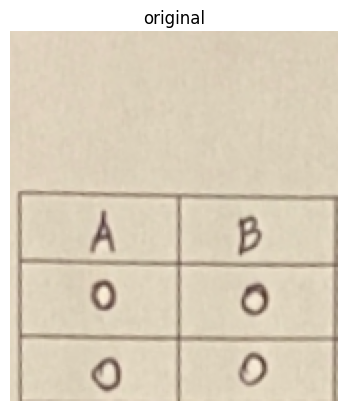

In [4]:
image = cv2.imread("../img/test4.png")
test=TextExtractionTable(image)
show_image("original",test.image)

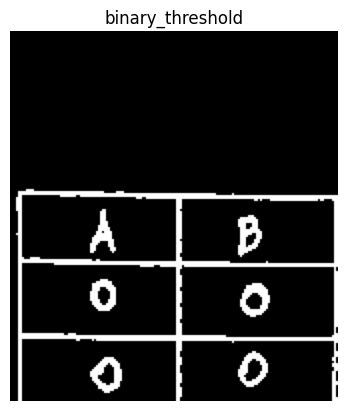

In [5]:
test.binary_threshold()
show_image("binary_threshold",test.image)

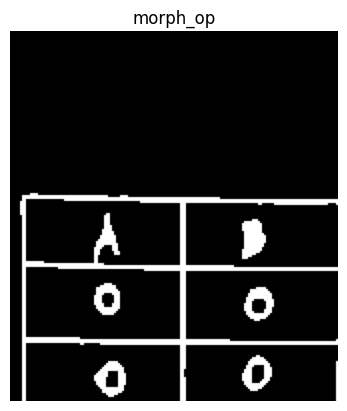

In [6]:
test.morph_op()
show_image("morph_op",test.image)

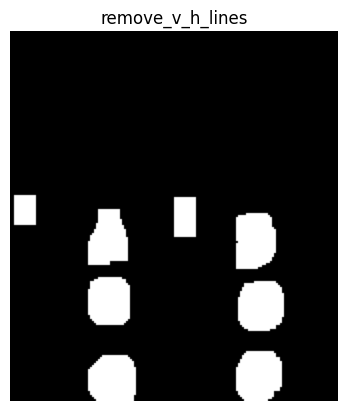

In [7]:
test.remove_v_h_lines()
show_image("remove_v_h_lines",test.image)

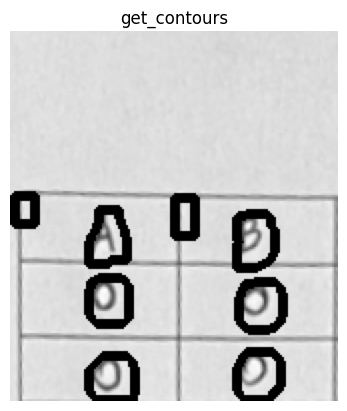

In [8]:
test.get_contours()
show_image_with_contours("get_contours",test.gscale_img,test.contours)

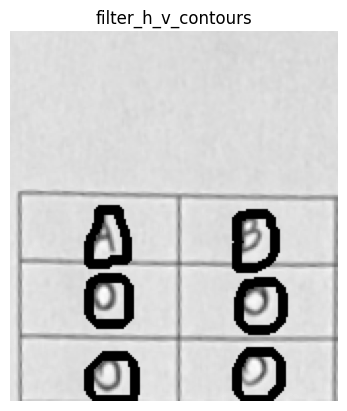

In [9]:
test.filter_h_contours()
test.filter_v_contours()
show_image_with_contours("filter_h_v_contours",test.gscale_img,test.contours)

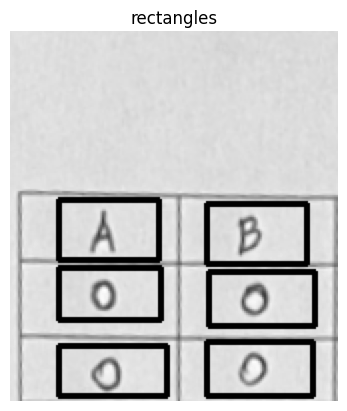

In [10]:
test.draw_rect()